In [1]:
import pandas as pd
import numpy as np
import yfinance
import mplfinance as mpf
import pandas as pd
import warnings
warnings.simplefilter("ignore")

name = '^NSEBANK'
ticker = yfinance.Ticker(name)
df = ticker.history(interval="1d",start="2019-06-01", end="2021-05-03")
df['Date'] = pd.to_datetime(df.index)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

h_df = ticker.history(interval="1h",start="2019-06-01", end="2021-05-03")
h_df['Date'] = pd.to_datetime(h_df.index)
h_df = h_df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

hour = []
j=0
c=0
for i in range(len(h_df['Date'])):
    date = h_df['Date'][j]
    if h_df['Date'][i]==date:
        hour.append(c+1)
        c+=1
    else:
        hour.append(1)
        c=1
        j=i
h_df['Hour']=hour

In [2]:
def date_presence(li, x):
    for date in li:
        if date==x:
            return True
    return False
#tol = 0.005*np.mean(df['Close'])

In [3]:
from stockstats import StockDataFrame

# daily macd
exp11_d = df['Close'].ewm(span=11, adjust=False).mean()
exp22_d = df['Close'].ewm(span=22, adjust=False).mean()
macd = exp11_d - exp22_d
signal = macd.ewm(span=9, adjust = False).mean()
exp50_d = df['Close'].ewm(span=50, adjust=False).mean()
df['macd_hist'] = macd - signal
df['exp11'] = exp11_d
df['exp22'] = exp22_d
df['exp50'] = exp50_d

# daily macd panel
colors_d = ['b']
for i in range(1, len(df['macd_hist'])):
    if df['macd_hist'][i] >= df['macd_hist'][i-1]:
        colors_d.append('b')
    elif df['macd_hist'][i] < df['macd_hist'][i-1]:
        colors_d.append('r')

#daily rsi
stock_d = StockDataFrame.retype(df.copy())
df['RSI'] = stock_d['rsi_14']

#DIVERGENCE IDENTIFICATION ON DAILY
crest_d = []
trough_d = []
for i in range(1, len(df['Date'])-1):
    if df['macd_hist'][i]>df['macd_hist'][i-1] and df['macd_hist'][i]>df['macd_hist'][i+1] and df['macd_hist'][i]>0:
        crest_d.append([i, df['Date'][i], df['macd_hist'][i], df['High'][i], df['RSI'][i]])
    elif df['macd_hist'][i]<df['macd_hist'][i-1] and df['macd_hist'][i]<df['macd_hist'][i+1] and df['macd_hist'][i]<0:
        trough_d.append([i, df['Date'][i], df['macd_hist'][i], df['Low'][i], df['RSI'][i]])
crest_d = pd.DataFrame(crest_d, columns = ['Index','Date', 'macd', 'High', 'RSI'])
trough_d = pd.DataFrame(trough_d, columns = ['Index','Date', 'macd', 'Low', 'RSI'])

bear_d = []
for i in crest_d.index[1:]:
    if crest_d['macd'][i]<crest_d['macd'][i-1] and crest_d['High'][i]>crest_d['High'][i-1] and crest_d['RSI'][i]<70:
        bear_d.append([crest_d['Index'][i-1], crest_d['Index'][i], crest_d['Date'][i-1], crest_d['Date'][i], crest_d['macd'][i-1], crest_d['macd'][i], crest_d['High'][i-1], crest_d['High'][i]])
bear_d = pd.DataFrame(bear_d, columns = ['Start Index','End Index','Start Date','End Date','Start MACD', 'End MACD', 'Start High', 'End High'])
#plot_bear_d_price = [df['High'][i] if date_presence(bear_d['End Date'], df['Date'][i]) else (np.nan) for i in range(len(df['Date']))]
#plot_bear_d_macd = [df['macd_hist'][i] if date_presence(bear_d['End Date'], df['Date'][i]) else (np.nan) for i in range(len(df['Date']))]
    
bull_d = []
for i in trough_d.index[1:]:
    if trough_d['macd'][i]>trough_d['macd'][i-1] and trough_d['Low'][i]<trough_d['Low'][i-1] and trough_d['RSI'][i]>30:
        bull_d.append([trough_d['Index'][i-1], trough_d['Index'][i], trough_d['Date'][i-1], trough_d['Date'][i], trough_d['macd'][i-1], trough_d['macd'][i], trough_d['Low'][i-1], trough_d['Low'][i]])
bull_d = pd.DataFrame(bull_d, columns = ['Start Index', 'End Index', 'Start Date', 'End Date','Start MACD', 'End MACD', 'Start Low', 'End Low'])
#plot_bull_d_price = [df['Low'][i] if date_presence(bull_d['End Date'], df['Date'][i]) else (np.nan) for i in range(len(df['Date']))]
#plot_bull_d_macd = [df['macd_hist'][i] if date_presence(bull_d['End Date'], df['Date'][i]) else (np.nan) for i in range(len(df['Date']))]



# hourly macd
exp11_h = h_df['Close'].ewm(span=11, adjust=False).mean()
exp22_h = h_df['Close'].ewm(span=22, adjust=False).mean()
macd_h = exp11_h - exp22_h
signal_h = macd_h.ewm(span=9, adjust = False).mean()
h_df['macd_hist'] = macd_h - signal_h
h_df['exp11'] = exp11_h
h_df['exp22'] = exp22_h
exp50_h = h_df['Close'].ewm(span=50, adjust=False).mean()
h_df['exp50'] = exp50_h

# hourly macd panel
colors_h = ['b']
for i in range(1, len(h_df['macd_hist'])):
    if h_df['macd_hist'][i] >= h_df['macd_hist'][i-1]:
        colors_h.append('b')
    elif h_df['macd_hist'][i] < h_df['macd_hist'][i-1]:
        colors_h.append('r')

#hourly rsi
stock_h = StockDataFrame.retype(h_df.copy())
h_df['RSI'] = stock_h['rsi_14']

#DIVERGENCE IDENTIFICATION ON HOURLY
crest_h = []
trough_h = []
for i in range(1, len(h_df['Date'])-1):
    if h_df['macd_hist'][i]>h_df['macd_hist'][i-1] and h_df['macd_hist'][i]>h_df['macd_hist'][i+1] and h_df['macd_hist'][i]>0:
        crest_h.append([i, h_df['Date'][i], h_df['Hour'][i], h_df['macd_hist'][i], h_df['High'][i], h_df['RSI'][i]])
    elif h_df['macd_hist'][i]<h_df['macd_hist'][i-1] and h_df['macd_hist'][i]<h_df['macd_hist'][i+1] and h_df['macd_hist'][i]<0:
        trough_h.append([i, h_df['Date'][i], h_df['Hour'][i], h_df['macd_hist'][i], h_df['Low'][i], h_df['RSI'][i]])
crest_h = pd.DataFrame(crest_h, columns = ['Index', 'Date', 'Hour', 'macd', 'High', 'RSI'])
trough_h = pd.DataFrame(trough_h, columns = ['Index', 'Date', 'Hour', 'macd', 'Low', 'RSI'])

bear_h = []
for i in crest_h.index[1:]:
    if crest_h['macd'][i]<crest_h['macd'][i-1] and crest_h['High'][i]>crest_h['High'][i-1] and crest_h['RSI'][i]<70:
        bear_h.append([crest_h['Index'][i-1], crest_h['Index'][i], crest_h['Date'][i-1], crest_h['Hour'][i-1], crest_h['Date'][i], crest_h['Hour'][i], crest_h['macd'][i-1], crest_h['macd'][i], crest_h['High'][i-1], crest_h['High'][i]])
bear_h = pd.DataFrame(bear_h, columns = ['Start Index', 'End Index', 'Start Date','Start Hour', 'End Date','End Hour', 'Start MACD', 'End MACD', 'Start High', 'End High'])
#plot_bear_h_price = [h_df['High'][i] if (np.where((bear_h['End Date']==h_df['Date'][i])&(bear_h['End Hour']==h_df['Hour'][i]))[0]).size>0 else (np.nan) for i in range(len(h_df['Date']))]
#plot_bear_h_macd = [h_df['macd_hist'][i] if (np.where((bear_h['End Date']==h_df['Date'][i])&(bear_h['End Hour']==h_df['Hour'][i]))[0]).size>0 else (np.nan) for i in range(len(h_df['Date']))]

bull_h = []
for i in trough_h.index[1:]:
    if trough_h['macd'][i]>trough_h['macd'][i-1] and trough_h['Low'][i]<trough_h['Low'][i-1] and trough_h['RSI'][i]>30:
        bull_h.append([trough_h['Index'][i-1], trough_h['Index'][i], trough_h['Date'][i-1], trough_h['Hour'][i-1], trough_h['Date'][i], trough_h['Hour'][i], trough_h['macd'][i], trough_h['macd'][i],trough_h['Low'][i-1], trough_h['Low'][i]])
bull_h = pd.DataFrame(bull_h, columns = ['Start Index', 'End Index', 'Start Date','Start Hour','End Date','End Hour','Start MACD', 'End MACD', 'Start Low', 'End Low'])
#plot_bull_h_price = [h_df['Low'][i] if (np.where((bull_h['End Date']==h_df['Date'][i])&(bull_h['End Hour']==h_df['Hour'][i]))[0]).size>0 else (np.nan) for i in range(len(h_df['Date']))]
#plot_bull_h_macd = [h_df['macd_hist'][i] if (np.where((bull_h['End Date']==h_df['Date'][i])&(bull_h['End Hour']==h_df['Hour'][i]))[0]).size>0 else (np.nan) for i in range(len(h_df['Date']))]


In [4]:
def plot_div_bull(div, df):
    df['plot_div_price'] = np.nan
    df['plot_div_macd'] = np.nan
    for i in div.index:
        start_index = div['Start Index'][i]
        end_index = div['End Index'][i]
        start_macd = div['Start MACD'][i]
        end_macd = div['End MACD'][i]
        start_low = div['Start Low'][i]
        end_low = div['End Low'][i]
        #finding the m for y=price_m*x+price_c plotting on candlesticks (prices)
        price_m = (end_low-start_low)/(end_index-start_index)
        price_c = start_low - price_m*start_index
        #plotting line values in the interval of divergence
        for x in range(div['Start Index'][i], div['End Index'][i]+1):
            df['plot_div_price'][x] = price_m*x + price_c
        #finding the m for y=macd_m*x+macd_c plotting on macd
        macd_m = (end_macd-start_macd)/(end_index-start_index)
        macd_c = start_macd - macd_m*start_index
        #plotting line values in the interval of divergence
        for x in range(div['Start Index'][i], div['End Index'][i]+1):
            df['plot_div_macd'][x] = macd_m*x + macd_c
    return df

h_df = plot_div_bull(bull_h, h_df)
df = plot_div_bull(bull_d, df)

def plot_div_bear(div, df):
    for i in div.index:
        start_index = div['Start Index'][i]
        end_index = div['End Index'][i]
        start_macd = div['Start MACD'][i]
        end_macd = div['End MACD'][i]
        start_high = div['Start High'][i]
        end_high = div['End High'][i]
        #finding the m for y=price_m*x+price_c plotting on candlesticks (prices)
        price_m = (end_high-start_high)/(end_index-start_index)
        price_c = start_high - price_m*start_index
        #plotting line values in the interval of divergence
        for x in range(div['Start Index'][i], div['End Index'][i]+1):
            df['plot_div_price'][x] = price_m*x + price_c
        #finding the m for y=macd_m*x+macd_c plotting on macd
        macd_m = (end_macd-start_macd)/(end_index-start_index)
        macd_c = start_macd - macd_m*start_index
        #plotting line values in the interval of divergence
        for x in range(div['Start Index'][i], div['End Index'][i]+1):
            df['plot_div_macd'][x] = macd_m*x + macd_c
    return df

h_df = plot_div_bear(bear_h, h_df)
df = plot_div_bear(bear_d, df)

In [5]:
bear_d.rename(columns={'End Date':'Date'}, inplace = True)
bull_d.rename(columns={'End Date':'Date'}, inplace = True)
bear_h.rename(columns={'End Date':'Date', 'End Hour':'Hour'}, inplace = True)
bull_h.rename(columns={'End Date':'Date', 'End Hour':'Hour'}, inplace = True)

df['Diff with 11 EMA'] = np.absolute(df['Close'] - df['exp11'])
df['Diff with 22 EMA'] = np.absolute(df['Close'] - df['exp22'])
h_df['Diff with 11 EMA'] = np.absolute(h_df['Close'] - h_df['exp11'])
h_df['Diff with 22 EMA'] = np.absolute(h_df['Close'] - h_df['exp22'])

In [6]:
buy_date_entry = []
buy_hour_entry = []
buy_ohlc_entry = []
d1_date = []
d1_hour = []
d1_ohlc = []
buy_cond = []

for date in h_df['Date'].unique():
    if date_presence(bull_h['Date'], date) and date_presence(bull_d['Date'], date):
        z = np.where(bull_h['Date']==date)[0]
        for hour_i in z:
            hour = bull_h['Hour'][hour_i]
            y = np.where((h_df['Date'] == date) & (h_df['Hour'] == hour))[0]
            for j in y:
                for k in range(j+1, min(j+36, len(h_df['Date']))):
                    if (h_df['High'][k] > h_df['High'][j]) and date_presence(buy_date_entry, h_df['Date'][k])==False:
                        buy_date_entry.append(h_df['Date'][k])
                        buy_hour_entry.append(h_df['Hour'][k])
                        buy_ohlc_entry.append((h_df['Open'][k], h_df['High'][k], h_df['Low'][k], h_df['Close'][k]))
                        d1_date.append(date)
                        d1_hour.append(hour)
                        d1_ohlc.append((h_df['Open'][j], h_df['High'][j], h_df['Low'][j], h_df['Close'][j]))
                        buy_cond.append('CONTRA-TREND TRADE')
                        break
    elif date_presence(bull_h['Date'], date):
        z = np.where(df['Date']==date)[0]
        for i in z:
            if ((df['High'][i]>=df['exp11'][i] and df['Low'][i]<=df['exp11'][i]) or (df['High'][i]>=df['exp22'][i] and df['Low'][i]<=df['exp22'][i])) and df['Close'][i] > df['exp50'][i]:
                y = np.where(bull_h['Date']==date)[0]
                for hour_i in y:
                    hour = bull_h['Hour'][hour_i]
                    w = np.where((h_df['Date'] == date) & (h_df['Hour'] == hour))[0]
                    for j in w:
                        for k in range(j+1, min(j+36, len(h_df['Date']))):
                            if h_df['High'][k] > h_df['High'][j] and date_presence(buy_date_entry, h_df['Date'][k])==False:
                                buy_date_entry.append(h_df['Date'][k])
                                buy_hour_entry.append(h_df['Hour'][k])
                                buy_ohlc_entry.append((h_df['Open'][k], h_df['High'][k], h_df['Low'][k], h_df['Close'][k]))
                                d1_date.append(date)
                                d1_hour.append(hour)
                                d1_ohlc.append((h_df['Open'][j], h_df['High'][j], h_df['Low'][j], h_df['Close'][j]))
                                buy_cond.append('RE-ENTRY TRADE')
                                break
    elif date_presence(bull_d['Date'], date):
        z = np.where(df['Date']==date)[0]
        for i in z:
            for k in range(i+1, min(i+6, len(df['Date']))):
                if df['High'][k] > df['High'][i] and date_presence(buy_date_entry, df['Date'][k])==False:
                    buy_date_entry.append(df['Date'][k])
                    buy_hour_entry.append(1)
                    buy_ohlc_entry.append((h_df['Open'][k], h_df['High'][k], h_df['Low'][k], h_df['Close'][k]))
                    d1_date.append(date)
                    d1_hour.append(1)
                    d1_ohlc.append((h_df['Open'][i], h_df['High'][i], h_df['Low'][i], h_df['Close'][i]))
                    buy_cond.append('DAILY DIVERGENCE TRADE')
                    break

buy = pd.DataFrame(list(zip(buy_cond, d1_date, d1_hour, d1_ohlc, buy_date_entry, buy_hour_entry, buy_ohlc_entry)),
                   columns = ['Stock: Condition','D1: Date','D1: Hour','D1: OHLC','Entry: Buy Date','Entry: Buy Candle on Hourly','Entry: Buy OHLC'])
pd.set_option('display.max_rows', None)

In [7]:
sell_date_entry = []
sell_hour_entry = []
sell_ohlc_entry = []
d1_date = []
d1_hour = []
d1_ohlc = []
sell_cond = []

for date in h_df['Date'].unique():
    if date_presence(bear_h['Date'], date) and date_presence(bear_d['Date'], date):
        z = np.where(bear_h['Date']==date)[0]
        for hour_i in z:
            hour = bear_h['Hour'][hour_i]
            y = np.where((h_df['Date'] == date) & (h_df['Hour'] == hour))[0]
            for j in y:
                for k in range(j+1, min(j+36, len(h_df['Date']))):
                    if (h_df['Low'][k] < h_df['Low'][j]) and date_presence(sell_date_entry, h_df['Date'][k])==False:
                        sell_date_entry.append(h_df['Date'][k])
                        sell_hour_entry.append(h_df['Hour'][k])
                        sell_ohlc_entry.append((h_df['Open'][k], h_df['High'][k], h_df['Low'][k], h_df['Close'][k]))
                        d1_date.append(date)
                        d1_hour.append(hour)
                        d1_ohlc.append((h_df['Open'][j], h_df['High'][j], h_df['Low'][j], h_df['Close'][j]))
                        sell_cond.append('CONTRA-TREND TRADE')
                        break
    elif date_presence(bear_h['Date'], date):
        z = np.where(df['Date']==date)[0]
        for i in z:
            if ((df['High'][i]>=df['exp11'][i] and df['Low'][i]<=df['exp11'][i]) or (df['High'][i]>=df['exp22'][i] and df['Low'][i]<=df['exp22'][i])) and df['Close'][i] < df['exp50'][i]:
                y = np.where(bear_h['Date']==date)[0]
                for hour_i in y:
                    hour = bear_h['Hour'][hour_i]
                    w = np.where((h_df['Date'] == date) & (h_df['Hour'] == hour))[0]
                    for j in w:
                        for k in range(j+1, min(j+36, len(h_df['Date']))):
                            if h_df['Low'][k] < h_df['Low'][j] and date_presence(sell_date_entry, h_df['Date'][k])==False:
                                sell_date_entry.append(h_df['Date'][k])
                                sell_hour_entry.append(h_df['Hour'][k])
                                sell_ohlc_entry.append((h_df['Open'][k], h_df['High'][k], h_df['Low'][k], h_df['Close'][k]))
                                d1_date.append(date)
                                d1_hour.append(hour)
                                d1_ohlc.append((h_df['Open'][j], h_df['High'][j], h_df['Low'][j], h_df['Close'][j]))
                                sell_cond.append('RE-ENTRY TRADE')
                                break
    elif date_presence(bear_d['Date'], date):
        z = np.where(df['Date']==date)[0]
        for i in z:
            for k in range(i+1, min(i+6, len(h_df['Date']))):
                if df['Low'][k] < df['Low'][i] and date_presence(sell_date_entry, df['Date'][k])==False:
                    sell_date_entry.append(df['Date'][k])
                    sell_hour_entry.append(1)
                    sell_ohlc_entry.append((h_df['Open'][k], h_df['High'][k], h_df['Low'][k], h_df['Close'][k]))
                    d1_date.append(date)
                    d1_hour.append(1)
                    d1_ohlc.append((h_df['Open'][i], h_df['High'][i], h_df['Low'][i], h_df['Close'][i]))
                    sell_cond.append('DAILY DIVERGENCE TRADE')
                    break
                
sell = pd.DataFrame(list(zip(sell_cond, d1_date, d1_hour, d1_ohlc, sell_date_entry, sell_hour_entry, sell_ohlc_entry)), 
                    columns = ['Stock: Condition','D1: Date','D1: Hour','D1: OHLC','Entry: Sell Date','Entry: Sell Candle on Hourly','Entry: Sell OHLC'])
pd.set_option('display.max_rows', None)

In [8]:
d1_date = []
d1_hour = []
d1_ohlc = []
d2_date = []
d2_hour = []
d2_ohlc = []
bed_or_bud = []
trade_entry_price = []
cond = []

for i in buy.index:
    d1_date.append(buy['D1: Date'][i])
    d1_hour.append(buy['D1: Hour'][i])
    d1_ohlc.append(buy['D1: OHLC'][i])
    (o,h,l,c) = buy['Entry: Buy OHLC'][i]
    d2_date.append(buy['Entry: Buy Date'][i])
    d2_hour.append(buy['Entry: Buy Candle on Hourly'][i])
    d2_ohlc.append((o,h,l,c))
    bed_or_bud.append('BuD')
    trade_entry_price.append(c)
    cond.append(buy['Stock: Condition'][i])
    
for i in sell.index:
    d1_date.append(sell['D1: Date'][i])
    d1_hour.append(sell['D1: Hour'][i])
    d1_ohlc.append(sell['D1: OHLC'][i])
    (o,h,l,c) = sell['Entry: Sell OHLC'][i]
    d2_date.append(sell['Entry: Sell Date'][i])
    d2_hour.append(sell['Entry: Sell Candle on Hourly'][i])
    d2_ohlc.append((o,h,l,c))
    bed_or_bud.append('BeD')
    trade_entry_price.append(c)
    cond.append(sell['Stock: Condition'][i])

trans = pd.DataFrame(list(zip(bed_or_bud, cond, d1_date, d1_hour, d1_ohlc, d2_date, d2_hour, d2_ohlc, trade_entry_price)),
                          columns = ['Stock: BuD/BeD','Stock: Condition','D1: Date','D1: Hour','D1: OHLC','D2: Date','D2: Hour','D2: OHLC','Trade: Entry Price'])
trans = trans.sort_values(by='D1: Date')
index = {i for i in range(len(trans.index))}
trans.reset_index(inplace=True)
trans.drop(columns=['index'], inplace=True)

In [9]:
trade_exit_date = []
trade_exit_hour = []
trade_exit_price = []
stop_loss = []

for i in trans.index:
    date = trans['D2: Date'][i]
    hour = trans['D2: Hour'][i]
    price = trans['Trade: Entry Price'][i]
    daily_j = int(np.where(df['Date']==date)[0])
    all_hourly_j = np.where((h_df['Date']==date) & (h_df['Hour']==hour))[0]
    for hourly_j in all_hourly_j:
        if trans['Stock: BuD/BeD'][i]=='BuD':
            stoploss = float(df['Low'][daily_j-1])
            for j in range(hourly_j+1, len(h_df['Date'])):
                flag = 0
                if h_df['High'][j] - price >= 2*np.absolute(price - stoploss):
                    trade_exit_date.append(h_df['Date'][j])
                    trade_exit_hour.append(h_df['Hour'][j])
                    trade_exit_price.append(h_df['High'][j])
                    stop_loss.append(stoploss)
                    flag = 1
                    break
                elif price - h_df['High'][j] >= np.absolute(price - stoploss):
                    trade_exit_date.append(h_df['Date'][j])
                    trade_exit_hour.append(h_df['Hour'][j])
                    trade_exit_price.append(h_df['High'][j])
                    stop_loss.append(stoploss)
                    flag = 1
                    break
                elif date_presence(bear_d, h_df['Date'][j]):
                    trade_exit_date.append(h_df['Date'][j])
                    trade_exit_hour.append(h_df['Hour'][j])
                    trade_exit_price.append(h_df['Close'][j])
                    stop_loss.append('N/A')
                    flag = 1
                    break
            if flag==0:
                trade_exit_date.append('N/A')
                trade_exit_hour.append('N/A')
                trade_exit_price.append('N/A') 
                stop_loss.append('N/A')
        else:
            stoploss = float(df['High'][daily_j-1])
            for j in range(hourly_j+1, len(h_df['Date'])):
                flag = 0
                if price - h_df['High'][j] >= 2*np.absolute(price - stoploss):
                    trade_exit_date.append(h_df['Date'][j])
                    trade_exit_hour.append(h_df['Hour'][j])
                    trade_exit_price.append(h_df['High'][j])
                    stop_loss.append(stoploss)
                    flag = 1
                    break
                elif h_df['High'][j] - price >= np.absolute(price - stoploss):
                    trade_exit_date.append(h_df['Date'][j])
                    trade_exit_hour.append(h_df['Hour'][j])
                    trade_exit_price.append(h_df['High'][j])
                    stop_loss.append(stoploss)
                    flag = 1
                    break
                elif date_presence(bull_d, h_df['Date'][j]):
                    trade_exit_date.append(h_df['Date'][j])
                    trade_exit_hour.append(h_df['Hour'][j])
                    trade_exit_price.append(h_df['Close'][j])
                    stop_loss.append('N/A')
                    flag = 1
                    break
            if flag==0:
                trade_exit_date.append('N/A')
                trade_exit_hour.append('N/A')
                trade_exit_price.append('N/A') 
                stop_loss.append('N/A')

trans['Trade: Exit Date'] = trade_exit_date
trans['Trade: Exit Hour'] = trade_exit_hour
trans['Trade: Exit Price'] = trade_exit_price
trans['Stoploss'] = stop_loss
PL = []
agg = 0
for i in trans.index:
    if trans['Trade: Exit Price'][i]!='N/A' and trans['Stock: BuD/BeD'][i]=='BeD':
        pl = trans['Trade: Entry Price'][i] - trans['Trade: Exit Price'][i]
        PL.append(pl/trans['Trade: Entry Price'][i]*100)
        agg = agg + pl/trans['Trade: Entry Price'][i]*100
    elif trans['Trade: Exit Price'][i]!='N/A' and trans['Stock: BuD/BeD'][i]=='BuD':
        pl = trans['Trade: Exit Price'][i] - trans['Trade: Entry Price'][i]
        PL.append(pl/trans['Trade: Entry Price'][i]*100)
        agg = agg + pl/trans['Trade: Entry Price'][i]*100
    else:
        PL.append('N/A')
trans['Profit/Loss'] = PL
trans['Stock: Name'] = name
cn = []

for i in trans.index:
    if trans['Profit/Loss'][i]!='N/A' and trans['Profit/Loss'][i] > 0:
        cn.append('YES')
    elif trans['Profit/Loss'][i]!='N/A' and trans['Profit/Loss'][i] < 0:
        cn.append('NO')
    else:
        cn.append('N/A')

trans['Stock: Correct or Not'] = cn
cols = trans.columns.tolist()
cols = cols[-2:] + cols[:-2]
trans = trans[cols]
pd.set_option('max_colwidth', 800)

In [10]:
print('Aggregate P/L %age = ' + str(agg))

Aggregate P/L %age = -100.77043792257375


In [11]:
c=0
for i in trans.index:
    if trans['Stock: Correct or Not'][i]=='YES':
        c=c+1
print('Success Rate %age = '+ str(c/len(trans['Stock: Correct or Not'])*100))

Success Rate %age = 36.666666666666664


In [21]:
import talib
candle_names = talib.get_function_groups()['Pattern Recognition']

candle_rankings = {
        "CDL3LINESTRIKE_Bull": 1,
        "CDL3LINESTRIKE_Bear": 2,
        "CDL3BLACKCROWS_Bull": 3,
        "CDL3BLACKCROWS_Bear": 3,
        "CDLEVENINGSTAR_Bull": 4,
        "CDLEVENINGSTAR_Bear": 4,
        "CDLTASUKIGAP_Bull": 5,
        "CDLTASUKIGAP_Bear": 5,
        "CDLINVERTEDHAMMER_Bull": 6,
        "CDLINVERTEDHAMMER_Bear": 6,
        "CDLMATCHINGLOW_Bull": 7,
        "CDLMATCHINGLOW_Bear": 7,
        "CDLABANDONEDBABY_Bull": 8,
        "CDLABANDONEDBABY_Bear": 8,
        "CDLBREAKAWAY_Bull": 10,
        "CDLBREAKAWAY_Bear": 10,
        "CDLMORNINGSTAR_Bull": 12,
        "CDLMORNINGSTAR_Bear": 12,
        "CDLPIERCING_Bull": 13,
        "CDLPIERCING_Bear": 13,
        "CDLSTICKSANDWICH_Bull": 14,
        "CDLSTICKSANDWICH_Bear": 14,
        "CDLTHRUSTING_Bull": 15,
        "CDLTHRUSTING_Bear": 15,
        "CDLINNECK_Bull": 17,
        "CDLINNECK_Bear": 17,
        "CDL3INSIDE_Bull": 20,
        "CDL3INSIDE_Bear": 56,
        "CDLHOMINGPIGEON_Bull": 21,
        "CDLHOMINGPIGEON_Bear": 21,
        "CDLDARKCLOUDCOVER_Bull": 22,
        "CDLDARKCLOUDCOVER_Bear": 22,
        "CDLIDENTICAL3CROWS_Bull": 24,
        "CDLIDENTICAL3CROWS_Bear": 24,
        "CDLMORNINGDOJISTAR_Bull": 25,
        "CDLMORNINGDOJISTAR_Bear": 25,
        "CDLXSIDEGAP3METHODS_Bull": 27,
        "CDLXSIDEGAP3METHODS_Bear": 26,
        "CDLTRISTAR_Bull": 28,
        "CDLTRISTAR_Bear": 76,
        "CDLGAPSIDESIDEWHITE_Bull": 46,
        "CDLGAPSIDESIDEWHITE_Bear": 29,
        "CDLEVENINGDOJISTAR_Bull": 30,
        "CDLEVENINGDOJISTAR_Bear": 30,
        "CDL3WHITESOLDIERS_Bull": 32,
        "CDL3WHITESOLDIERS_Bear": 32,
        "CDLONNECK_Bull": 33,
        "CDLONNECK_Bear": 33,
        "CDL3OUTSIDE_Bull": 34,
        "CDL3OUTSIDE_Bear": 39,
        "CDLRICKSHAWMAN_Bull": 35,
        "CDLRICKSHAWMAN_Bear": 35,
        "CDLSEPARATINGLINES_Bull": 36,
        "CDLSEPARATINGLINES_Bear": 40,
        "CDLLONGLEGGEDDOJI_Bull": 37,
        "CDLLONGLEGGEDDOJI_Bear": 37,
        "CDLHARAMI_Bull": 38,
        "CDLHARAMI_Bear": 72,
        "CDLLADDERBOTTOM_Bull": 41,
        "CDLLADDERBOTTOM_Bear": 41,
        "CDLCLOSINGMARUBOZU_Bull": 70,
        "CDLCLOSINGMARUBOZU_Bear": 43,
        "CDLTAKURI_Bull": 47,
        "CDLTAKURI_Bear": 47,
        "CDLDOJISTAR_Bull": 49,
        "CDLDOJISTAR_Bear": 51,
        "CDLHARAMICROSS_Bull": 50,
        "CDLHARAMICROSS_Bear": 80,
        "CDLADVANCEBLOCK_Bull": 54,
        "CDLADVANCEBLOCK_Bear": 54,
        "CDLSHOOTINGSTAR_Bull": 55,
        "CDLSHOOTINGSTAR_Bear": 55,
        "CDLMARUBOZU_Bull": 71,
        "CDLMARUBOZU_Bear": 57,
        "CDLUNIQUE3RIVER_Bull": 60,
        "CDLUNIQUE3RIVER_Bear": 60,
        "CDL2CROWS_Bull": 61,
        "CDL2CROWS_Bear": 61,
        "CDLBELTHOLD_Bull": 62,
        "CDLBELTHOLD_Bear": 63,
        "CDLHAMMER_Bull": 65,
        "CDLHAMMER_Bear": 65,
        "CDLHIGHWAVE_Bull": 67,
        "CDLHIGHWAVE_Bear": 67,
        "CDLSPINNINGTOP_Bull": 69,
        "CDLSPINNINGTOP_Bear": 73,
        "CDLUPSIDEGAP2CROWS_Bull": 74,
        "CDLUPSIDEGAP2CROWS_Bear": 74,
        "CDLGRAVESTONEDOJI_Bull": 77,
        "CDLGRAVESTONEDOJI_Bear": 77,
        "CDLHIKKAKEMOD_Bull": 82,
        "CDLHIKKAKEMOD_Bear": 81,
        "CDLHIKKAKE_Bull": 85,
        "CDLHIKKAKE_Bear": 83,
        "CDLENGULFING_Bull": 84,
        "CDLENGULFING_Bear": 91,
        "CDLMATHOLD_Bull": 86,
        "CDLMATHOLD_Bear": 86,
        "CDLHANGINGMAN_Bull": 87,
        "CDLHANGINGMAN_Bear": 87,
        "CDLRISEFALL3METHODS_Bull": 94,
        "CDLRISEFALL3METHODS_Bear": 89,
        "CDLKICKING_Bull": 96,
        "CDLKICKING_Bear": 102,
        "CDLDRAGONFLYDOJI_Bull": 98,
        "CDLDRAGONFLYDOJI_Bear": 98,
        "CDLCONCEALBABYSWALL_Bull": 101,
        "CDLCONCEALBABYSWALL_Bear": 101,
        "CDL3STARSINSOUTH_Bull": 103,
        "CDL3STARSINSOUTH_Bear": 103,
        "CDLDOJI_Bull": 104,
        "CDLDOJI_Bear": 104,
        "CDLLONGLINE_Bull": 53,
        "CDLLONGLINE_Bear": 53,
        "CDLSHORTLINE_Bull": 85,
        "CDLSHORTLINE_Bear": 66,
        "CDLSTALLEDPATTERN_Bull": 93,
        "CDLSTALLEDPATTERN_Bear": 93,
        "CDLKICKINGBYLENGTH": 96,
        "CDLKICKINGBYLENGTH_Bear": 102
}
from itertools import compress
import operator

def candlesticks(df):
    op = df['Open']
    hi = df['High']
    lo = df['Low']
    cl = df['Close']
    # create columns for each pattern
    for candle in candle_names:
    # below is same as;
    # df["CDL3LINESTRIKE"] = talib.CDL3LINESTRIKE(op, hi, lo, cl)
        df[candle] = getattr(talib, candle)(op, hi, lo, cl)
    df['candlestick_pattern'] = np.nan
    df['candlestick_match_count'] = np.nan
    for index, row in df.iterrows():
            # no pattern found
        if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
            df.loc[index,'candlestick_pattern'] = ""
            df.loc[index, 'candlestick_match_count'] = 0
            # single pattern found
        elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
                # bull pattern 100 or 200
            if any(row[candle_names].values > 0):
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bull'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1
                # bear pattern -100 or -200
            else:
                pattern = list(compress(row[candle_names].keys(), row[candle_names].values != 0))[0] + '_Bear'
                df.loc[index, 'candlestick_pattern'] = pattern
                df.loc[index, 'candlestick_match_count'] = 1
            # multiple patterns matched -- select best performance
        else:
                # filter out pattern names from bool list of values
            patterns = list(compress(row[candle_names].keys(), row[candle_names].values != 0))
            container = []
            for pattern in patterns:
                if row[pattern] > 0:
                    container.append(pattern + '_Bull')
                else:
                    container.append(pattern + '_Bear')
            rank_list = [candle_rankings[p] for p in container]
            if len(rank_list) == len(container):
                rank_index_best = rank_list.index(min(rank_list))
                df.loc[index, 'candlestick_pattern'] = container[rank_index_best]
                df.loc[index, 'candlestick_match_count'] = len(container)
        # clean up candle columns
    df.drop(candle_names, axis = 1, inplace = True)
    return df

In [23]:
df = candlesticks(df)
df['candlestick_pattern'][15][-4:]

'Bull'

In [13]:
def gap_analysis(df):
    df['Gaps']=''
    for i in range(1, len(df.index)):
        if df['Low'][i] > df['High'][i-1]:
            ul = df['Low'][i]
            ll = df['High'][i-1]
            for j in range(i+1, len(df.index)):
                if df['Close'][j] > ll and df['Close'][j] < ul:
                    df['Gaps'][j] = 'RISING GAP'
                    break
        elif df['High'][i] < df['Low'][i-1]:
            ul = df['Low'][i-1]
            ll = df['High'][i]
            for j in range(i+1, len(df.index)):
                if df['Close'][j] > ll and df['Close'][j] < ul:
                    df['Gaps'][j] = 'FALLING GAP'
    return df

df = gap_analysis(df)
h_df = gap_analysis(h_df)
h_df.drop(columns=['candlestick_match_count'], inplace=True)
df.drop(columns=['candlestick_match_count'], inplace=True)

In [14]:
def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
    return support
def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
    return resistance
s =  np.mean(df['High'] - df['Low'])

def isFarFromLevel(l, levels):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

def sup_res(df):
    level_sup = []
    level_res = []
    for i in range(2,df.shape[0]-2):
        if isSupport(df,i):
            l = df['Low'][i]
            if isFarFromLevel(l, level_sup):
                level_sup.append((i,l))
        elif isResistance(df,i):
            l = df['High'][i]
            if isFarFromLevel(l, level_res):
                level_res.append((i,l))
    df['Sup/Res'] = ''
    for i in range(len(df.index)):
        higher_price = max(df['Open'][i], df['Close'][i])
        lower_price = min(df['Open'][i], df['Close'][i])
        supres = []
        for (a,b) in level_sup:
            if higher_price>=b and lower_price<=b:
                supres.append('SUPPORT')
        for (a,b) in level_res:
            if higher_price>=b and lower_price<=b:
                supres.append('RESISTANCE')
        df['Sup/Res'][i] = supres
    return df

df = sup_res(df)
h_df = sup_res(h_df)

In [15]:
h_df['plot_D2_buy'] = np.nan
h_df['plot_D2_sell'] = np.nan
for i in trans.index:
    d2_date = trans['D2: Date'][i]
    d2_hour = trans['D2: Hour'][i]
    y = int(np.where((h_df['Date']==d2_date)&(h_df['Hour']==d2_hour))[0])
    if trans['Stock: BuD/BeD'][i] == 'BuD':
        h_df['plot_D2_buy'][y] = trans['Trade: Entry Price'][i]
    else:
        h_df['plot_D2_sell'][y] = trans['Trade: Entry Price'][i]

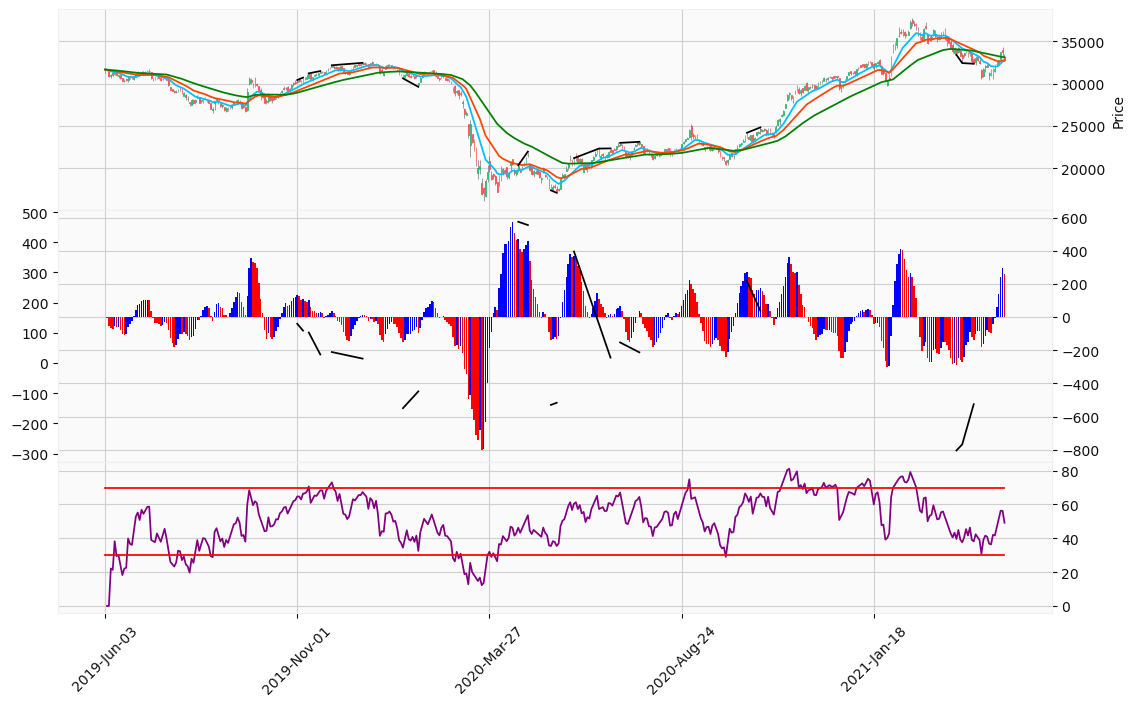

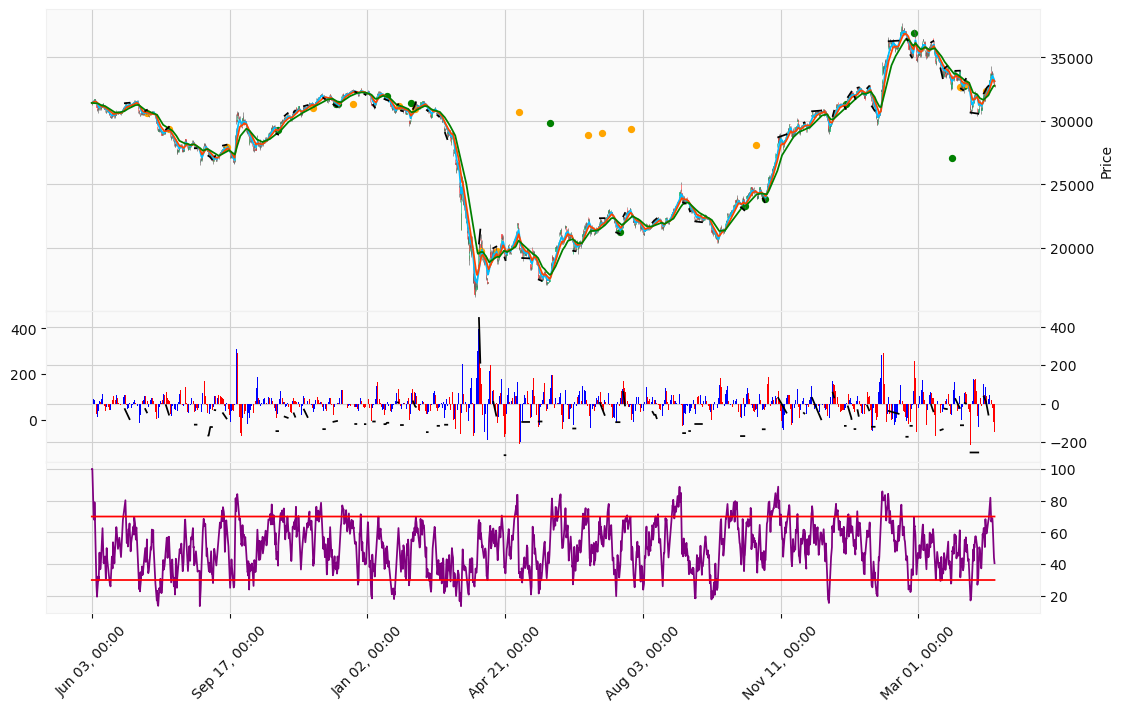

In [16]:
# daily plot
ap_d = [mpf.make_addplot(df['RSI'], type = 'line', panel = 2, color = 'purple'), 
        mpf.make_addplot([70 for i in range(len(df['Date']))],panel=2, color='r'), 
        mpf.make_addplot([30 for i in range(len(df['Date']))],panel=2, color='r'),
        mpf.make_addplot(df['macd_hist'], type='bar', panel=1, color=colors_d),
        mpf.make_addplot(df['plot_div_macd'], type = 'line', panel=1, color = 'black'),
        mpf.make_addplot(df['exp11'], type='line', panel=0, color = 'deepskyblue'),
        mpf.make_addplot(df['exp22'], type='line', panel=0, color = 'orangered'),
        mpf.make_addplot(df['exp50'], type='line', panel=0, color = 'green'),
        mpf.make_addplot(df['plot_div_price'], type='line', panel=0, color = 'black')]

mpf.plot(df, type='candle', figscale=1.5, figratio=(8,5), main_panel=0, panel_ratios=(4,5,3), addplot = ap_d, 
         style='yahoo', show_nontrading = False, volume = False)

# hourly plot
ap_h = [mpf.make_addplot(h_df['RSI'], type = 'line', panel = 2, color = 'purple'), 
        mpf.make_addplot([70 for i in range(len(h_df['Date']))], panel=2, color='r'), 
        mpf.make_addplot([30 for i in range(len(h_df['Date']))], panel=2, color='r'),
        mpf.make_addplot(h_df['macd_hist'], type='bar', panel=1, color=colors_h),
        mpf.make_addplot(h_df['plot_div_macd'], type = 'line', panel=1, color = 'black'),
        mpf.make_addplot(h_df['exp11'], type='line', panel=0, color = 'deepskyblue'),
        mpf.make_addplot(h_df['exp22'], type='line', panel=0, color = 'orangered'),
        mpf.make_addplot(h_df["exp50"], type='line', panel=0, color='green'),
        mpf.make_addplot(h_df["plot_D2_buy"], type='scatter', panel=0, color='green'),
        mpf.make_addplot(h_df["plot_D2_sell"], type='scatter', panel=0, color='orange'),
        mpf.make_addplot(h_df['plot_div_price'], type='line', panel=0, color = 'black')]
    
mpf.plot(h_df, type='candle', figscale=1.5, figratio=(8,5), main_panel=0, panel_ratios=(6,3,3), addplot = ap_h, style='yahoo', show_nontrading = False, volume = False)

In [17]:
trans

,Stock: Name,Stock: Correct or Not,Stock: BuD/BeD,Stock: Condition,D1: Date,D1: Hour,D1: OHLC,D2: Date,D2: Hour,D2: OHLC,Trade: Entry Price,Trade: Exit Date,Trade: Exit Hour,Trade: Exit Price,Stoploss,Profit/Loss
0,^NSEBANK,NO,BeD,RE-ENTRY TRADE,2019-07-12,5,"(30730.400390625, 30861.400390625, 30730.400390625, 30790.80078125)",2019-07-12,6,"(30791.30078125, 30835.80078125, 30564.650390625, 30588.099609375)",30588.099609,2019-07-17 00:00:00,2,30799.3,30787,-0.690468
1,^NSEBANK,YES,BeD,RE-ENTRY TRADE,2019-07-30,1,"(29434.849609375, 29528.30078125, 29336.150390625, 29420.400390625)",2019-07-30,2,"(29422.80078125, 29425.900390625, 29335.94921875, 29355.900390625)",29355.900391,2019-07-30 00:00:00,7,28818.8,29583.4,1.82945
2,^NSEBANK,YES,BeD,RE-ENTRY TRADE,2019-09-13,7,"(28105.650390625, 28124.900390625, 28080.150390625, 28103.349609375)",2019-09-16,1,"(27868.0, 27983.69921875, 27802.099609375, 27972.150390625)",27972.150391,2019-09-17 00:00:00,4,27644.1,28126.8,1.17295
3,^NSEBANK,YES,BuD,RE-ENTRY TRADE,2019-10-25,5,"(29181.599609375, 29222.349609375, 28932.400390625, 28972.349609375)",2019-10-25,6,"(28972.25, 29278.150390625, 28926.19921875, 29260.0)",29260.000000,2019-10-29 00:00:00,2,29809.4,28994.2,1.87765
4,^NSEBANK,NO,BeD,DAILY DIVERGENCE TRADE,2019-11-20,1,"(30809.19921875, 31008.0, 30773.75, 30944.75)",2019-11-22,1,"(30967.25, 31018.349609375, 30934.599609375, 30996.400390625)",30996.400391,2019-11-25 00:00:00,5,31539.8,31463.2,-1.75327
5,^NSEBANK,YES,BuD,RE-ENTRY TRADE,2019-12-10,2,"(31305.94921875, 31338.30078125, 31232.44921875, 31258.150390625)",2019-12-10,4,"(31274.400390625, 31378.5, 31219.25, 31326.19921875)",31326.199219,2019-12-13 00:00:00,1,31934.8,31122.1,1.94263
6,^NSEBANK,YES,BuD,RE-ENTRY TRADE,2019-12-10,6,"(31232.19921875, 31239.0, 31127.5, 31149.75)",2019-12-11,1,"(31151.650390625, 31337.099609375, 31151.650390625, 31319.75)",31319.750000,2019-12-12 00:00:00,7,31709.9,31126,1.24586
7,^NSEBANK,NO,BeD,DAILY DIVERGENCE TRADE,2019-12-20,1,"(31316.900390625, 31379.599609375, 31302.94921875, 31357.650390625)",2019-12-23,1,"(31357.55078125, 31372.94921875, 31281.099609375, 31325.650390625)",31325.650391,2019-12-23 00:00:00,2,32500.3,32443.3,-3.74996
8,^NSEBANK,NO,BuD,RE-ENTRY TRADE,2020-01-16,2,"(31922.75, 31928.900390625, 31695.94921875, 31721.150390625)",2020-01-16,5,"(31873.55078125, 31937.80078125, 31826.900390625, 31920.900390625)",31920.900391,2020-01-17 00:00:00,6,31653.7,31670.3,-0.837073
9,^NSEBANK,YES,BeD,RE-ENTRY TRADE,2020-01-24,4,"(31234.05078125, 31305.599609375, 31201.30078125, 31303.5)",2020-01-27,1,"(31110.55078125, 31187.44921875, 30926.5, 31159.650390625)",31159.650391,2020-01-30 00:00:00,2,30661.8,31375.4,1.5979
